In [413]:
from builtins import sorted
import ffmpeg
import librosa
import librosa.display
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import re
import os
import sys
import shutil
import pandas as pd
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore') #for reading mp3

#librosa==0.7.2
#numba==0.43

In [414]:
genres_list = ['disco', 'reggae', 'pop', 'rock',
               'metal', 'jazz', 'blues', 'hiphop', 'country']

template_types = ['binary', 'ks', 'harmonic']
chroma_operations = ['stft', 'cqt', 'cens']

binary_correct_accumulate_dict = {'disco': 0, 'reggae': 0, 'pop': 0, 'rock': 0,
                                  'metal': 0, 'jazz': 0, 'blues': 0, 'hiphop': 0, 'country': 0}

binary_file_num_dict = {'disco': 0, 'reggae': 0, 'pop': 0, 'rock': 0,
                        'metal': 0, 'jazz': 0, 'blues': 0, 'hiphop': 0, 'country': 0}

moving_scale = {0: '15', 1: '16', 2: '17', 3: '18', 4: '19', 5: '20',
                6: '21', 7: '22', 8: '23', 9: '0', 10: '1', 11: '2',
                12: '3', 13: '4', 14: '5', 15: '6', 16: '7', 17: '8',
                18: '9', 19: '10', 20: '11', 21: '12', 22: '13', 23: '14',
                }

# annotation_major_scale = ['A', 'A#', 'B', 'C', 'C#','D',
#                           'D#', 'E', 'F', 'F#', 'G', 'G#']

# annotation_minor_scale = ['a', 'a#', 'b', 'c', 'c#', 'd',
#                           'd#', 'e', 'f', 'f#', 'g', 'g#']

annotation_major_scale = {'A':0, 'A#':1, 'Bb':1, 'B':2, 'C':3, 'C#':4, 'Db':4,'D':5,
                          'D#':6, 'Eb':6, 'E':7, 'F':8, 'F#':9, 'Gb':9, 'G':10, 'G#':11, 'Ab':11}

annotation_minor_scale = {'a':12, 'a#':13, 'bb':13, 'b':14, 'c':15, 'c#':16, 'db':16, 'd':17,
                          'd#':18, 'eb':18, 'e':19, 'f':20, 'f#':21, 'gb':21, 'g':22, 'g#':23, 'ab':23}

octave_scale = ['C', 'C#', 'D', 'D#', 'E', 'F',
                'F#', 'G', 'G#', 'A', 'A#', 'B']

recording_version = ['HU33', 'SC06', 'FI66', 'FI80']
file_type = ['HU33', 'SC06', 'FI66', 'FI80', 'midi']
audio_file_format = {"HU33":".wav", "SC06":".wav", "FI66":".mp3", "FI80":".mp3", "midi":".mid"}


In [415]:
# -- 1) binary-valued template matching
# -- 2) K-S template matching
# -- 3) harmonic template matching (try 𝛼 = 0.9).
# -- Using Cicular Shifting to generate another tone

binary_C_major = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]
binary_C_minor = [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]

# -- C, C#, D, D#, E, F, F#, G, G#, A, A#, B
KS_C_major = [6.35, 2.23, 3.48, 2.33, 4.38,
              4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
KS_C_minor = [6.33, 2.68, 3.52, 5.38, 2.60,
              3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]

binary_templates = [binary_C_major, binary_C_minor]
ks_templates = [KS_C_major, KS_C_minor]

alpha = 0.9

# C Major harmonic template
C_major_harmonic_template = [1 + alpha + alpha**3 + alpha**7, 0, 0, 0, alpha**4, 0,
                             0, alpha**2+alpha**5, 0, 0, alpha**6, 0]

all_pitches_harmonic_template = [0] * 12

# Get all pitchs harmonic template
for i in range(12):
    all_pitches_harmonic_template[i] = np.roll(C_major_harmonic_template, i-3)

harmonic_major_template = [0] * 12
harmonic_minor_template = [0] * 12

for i in range(12):
    if binary_templates[0][i] == 1:
        harmonic_major_template += all_pitches_harmonic_template[(i + 3) % 12]

for i in range(12):
    if binary_templates[1][i] == 1:
        harmonic_minor_template += all_pitches_harmonic_template[(i + 3) % 12]

harmonic_templates = [harmonic_major_template, harmonic_minor_template]

templates = {'binary':binary_templates, 'ks':ks_templates, 'harmonic':harmonic_templates}

In [416]:
# local key 調式標記
ann_audio_localkey_dict = {}
for format in recording_version:
    ann_audio_localkey_dict[format] = {}
    for i in range(1, 25):
        ann_audio_localkey_df = pd.read_csv("./HW1 Datasets/SWD/SWD/02_Annotations/ann_audio_localkey-ann1/Schubert_D911-" + str(i).zfill(2) + '_' + format + ".csv", sep=';')
        #print(ann_audio_localkey_df)
        ann_audio_localkey_dict[format][i] = ann_audio_localkey_df

# print(ann_audio_localkey_dict)

In [417]:
def replace_key(row):
    if (row.find('maj') != -1):
        return annotation_major_scale[row.split(':')[0]]
    elif (row.find('min') != -1):
        return annotation_minor_scale[row.split(':')[0].lower()]

In [418]:
for format in recording_version:
    for i in range(1, 25):
        ann_audio_localkey_dict[format][i]['ann_key'] = ann_audio_localkey_dict[format][i]['key'].apply(replace_key)
# print(ann_audio_localkey_dict)

In [419]:
ann_audio_localkey_dict['HU33'][1]

,start,end,key,ann_key
0,1.26,31.68,C:min,15
1,31.68,40.56,D#:maj,6
2,40.56,49.00,G#:maj,11
3,49.00,98.92,C:min,15
4,98.92,107.80,D#:maj,6
5,107.80,116.24,G#:maj,11
6,116.24,147.86,C:min,15
7,147.86,166.52,C:min,15
8,166.52,175.44,D#:maj,6
9,175.44,184.00,G#:maj,11


In [420]:
# 小節與時間的對應表
time_bar_dict = {}

for i in range(1, 25):
    time_bar_dict_df = pd.read_csv( "./HW1 Datasets/time_per_measure_ann_score_localkey-ann1/time_per_measure_ann_score_localkey-ann1/Schubert_D911-" + str(i).zfill(2) + ".csv", sep=',')
    time_bar_dict[i] = time_bar_dict_df

# print(time_bar_dict)

In [421]:
time_bar_dict[1]

,Measure,Time
0,1.0,0.00
1,2.0,2.18
2,3.0,4.36
3,4.0,6.54
4,5.0,8.72
...,...,...
133,134.0,289.94
134,135.0,292.12
135,136.0,294.30
136,137.0,296.48


In [422]:
def predict_key(chroma, major_template, minor_template, tonic_pitch: int):
    # Just compare with tonic pitch's Major and minor chromagram
    # print(chroma.shape)
    major_corelation_coefficient = stats.pearsonr(chroma, np.roll(major_template, -3 + tonic_pitch))[0]
    minor_corelation_coefficient = stats.pearsonr(chroma, np.roll(minor_template, -3 + tonic_pitch))[0]

    if major_corelation_coefficient > minor_corelation_coefficient:
        # Major
        return tonic_pitch
    else:
        # minor
        return tonic_pitch+12

## 0.1 second 作為 timestep
在 sample rate 為 22050 情況下，n_fft = 2205，將使 window length 等於 0.1s (2205/ 22050 = 0.1)。<br/>

In [470]:
# If exist then delete it first
def prediction_generate(input_mean_pool_range:int):
    analysis_path = "./temp/SWD_analysis_Q4/"
    # try:
    #     shutil.rmtree(analysis_path)
    # except OSError as e:
    #     print("Error: %s - %s." % (e.filename, e.strerror))
    visualization = 0
    prediction_dict = {}
    tempo_dict = {}

    for format in file_type:
        prediction_dict[format] = {}
        tempo_dict[format] = {}
        if format == 'midi':
            for song_no in range(1, 25):
                prediction_dict[format][song_no] = {}
                #print("midi: ", format)
                midi_data = pretty_midi.PrettyMIDI("./HW1 Datasets/SWD/SWD/01_RawData/score_midi/Schubert_D911-" + str(song_no).zfill(2) + audio_file_format[format])

                tempo_dict[format][song_no] = midi_data.estimate_tempo()
                
                chroma_midi = midi_data.get_chroma(fs=10) # each column is spaced apart by 1./fs seconds.(1/10 = 0.1)

                filename = "./temp/SWD_analysis_Q4/chroma/" + format + "/"  + str(song_no).zfill(2) + ".txt"
                os.makedirs(os.path.dirname(filename), exist_ok=True)
                with open(filename, mode='w') as f:
                    np.savetxt(filename, chroma_midi)
                
                chroma_mean_pool = chroma_midi
                
                mean_pool_range = input_mean_pool_range
                pitches = chroma_midi.shape[0]
                frames = chroma_midi.shape[1]
                print("midi | song no.", song_no, " | length", frames)
                
                for timestep in range(frames):
                    for pitch in range(pitches):
                        if timestep < int(mean_pool_range/2):
                            chroma_mean_pool[pitch][timestep] = np.mean(chroma_midi[pitch][ : int(mean_pool_range/2)]).T
                        elif timestep > frames - mean_pool_range:
                            chroma_mean_pool[pitch][timestep] = np.mean(chroma_midi[pitch][timestep - int(mean_pool_range/2) : ]).T
                        else:
                            chroma_mean_pool[pitch][timestep] = np.mean(chroma_midi[pitch][(timestep - int(mean_pool_range/2)) : (timestep + int(mean_pool_range/2))]).T
                #print(chroma_mean_pool['midi'])
                if visualization == 1:
                    plt.plot(y)
                    plt.figure(figsize=(15, 5))
                    plt.subplot(1, 1, 1)
                    librosa.display.specshow(chroma_mean_pool, y_axis='chroma')
                    plt.title('midi')
                    plt.colorbar()
                    plt.show()

                
                for template_type in template_types:
                    prediction_dict[format][song_no][template_type] = []

                    filename = './temp/SWD_analysis_Q4/' + format + '/' + str(input_mean_pool_range) + '/' + str(song_no) + '/' + template_type + '.txt'
                    os.makedirs(os.path.dirname(filename), exist_ok=True)
                    with open(filename, mode='w') as f:
                        for timestep in range(frames):
                            #print(chroma_mean_pool['midi'][:,timestep])
                            tonic_pitch = (chroma_mean_pool[:,timestep].argmax() + 3) % 12
                            #print("tonic_pitch:", tonic_pitch)
                            local_key = predict_key(chroma_mean_pool[:,timestep],
                                                    templates[template_type][0],
                                                    templates[template_type][1],
                                                    tonic_pitch)
                            prediction_dict[format][song_no][template_type].append(local_key)
                            f.write(str(local_key) + '\n') # timestamp = 0.1, 0.2, 0.3, 0.4 ...etc.
        else:
            for song_no in range(1, 25):
                prediction_dict[format][song_no] = {}
                
                y, sr = librosa.load(r"./HW1 Datasets/SWD/SWD/01_RawData/audio_wav/" + format +
                                    "/Schubert_D911-" + str(song_no).zfill(2) + "_" + format +
                                    audio_file_format[format])

                onset_env = librosa.onset.onset_strength(y=y, sr=sr)
                tempo_temp = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
                tempo_dict[format][song_no] = tempo_temp
                
                # -- STFT chromagram
                chroma_stft = librosa.feature.chroma_stft(
                    y=y, sr=sr, n_chroma=12, n_fft=2205, hop_length=int(sr*0.1))
                
                # -- CQT chromagram
                chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=int(sr*0.1)) #0.14668
                
                # -- Chroma Energy Normalized chromagram
                chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr, hop_length=int(sr*0.1))
                
                # Make sure the three method have same length of chromagram
                # print("chroma_stft shape", chroma_stft.shape)
                # print("chroma_cqt shape", chroma_cqt.shape)
                # print("chroma_cens shape", chroma_cens.shape)

                chroma_mean_pool = {}

                chroma_mean_pool['stft'] = chroma_stft
                chroma_mean_pool['cqt'] = chroma_cqt
                chroma_mean_pool['cens'] = chroma_cens

                # 0.1(second) * 300 = 30 (second)
                mean_pool_range = input_mean_pool_range
                pitches = chroma_stft.shape[0]
                frames = chroma_stft.shape[1] # better be 2986.6
                print(format, " | song no.", song_no, " | length", frames)

                for chroma_operation in chroma_operations:
                    prediction_dict[format][song_no][chroma_operation] = {}
                    for timestep in range(frames):
                        for pitch in range(pitches):
                            if timestep < int(mean_pool_range/2):
                                chroma_mean_pool[chroma_operation][pitch][timestep] = np.mean(chroma_mean_pool[chroma_operation][pitch][ : int(mean_pool_range/2)]).T
                            elif timestep > frames - mean_pool_range:
                                chroma_mean_pool[chroma_operation][pitch][timestep] = np.mean(chroma_mean_pool[chroma_operation][pitch][timestep - int(mean_pool_range/2) : ]).T
                            else:
                                chroma_mean_pool[chroma_operation][pitch][timestep] = np.mean(chroma_mean_pool[chroma_operation][pitch][(timestep - int(mean_pool_range/2)) : (timestep + int(mean_pool_range/2))]).T
                    #print(chroma_mean_pool[chroma_operation])
                    if visualization == 1:
                        plt.plot(y)
                        plt.figure(figsize=(15, 5))
                        plt.subplot(1, 1, 1)
                        librosa.display.specshow(chroma_mean_pool[chroma_operation], y_axis='chroma')
                        plt.title(chroma_operation)
                        plt.colorbar()
                        plt.show()

                for chroma_operation in chroma_operations:
                    prediction_dict[format][song_no][chroma_operation] = {}
                    for template_type in template_types:
                        prediction_dict[format][song_no][chroma_operation][template_type] = []

                        filename = './temp/SWD_analysis_Q4/' + format + '/' + str(input_mean_pool_range) + '/' + str(song_no) + '/' + chroma_operation + '/' + template_type + '.txt'
                        os.makedirs(os.path.dirname(filename), exist_ok=True)
                        with open(filename, mode='w') as f:
                            for timestep in range(frames):
                                #print(chroma_mean_pool[chroma_operation][:,timestep])
                                tonic_pitch = (chroma_mean_pool[chroma_operation][:,timestep].argmax() + 3) % 12
                                #print("tonic_pitch:", tonic_pitch)
                                local_key = predict_key(chroma_mean_pool[chroma_operation][:,timestep],
                                                        templates[template_type][0],
                                                        templates[template_type][1],
                                                        tonic_pitch)
                                prediction_dict[format][song_no][chroma_operation][template_type].append(local_key)
                                f.write(str(local_key) + '\n') # timestamp = 0.1, 0.2, 0.3, 0.4 ...etc.

    return prediction_dict, tempo_dict

In [471]:
prediction_dict, tempo_dict = prediction_generate(300)

HU33  | song no. 1  | length 3117
HU33  | song no. 2  | length 1012
HU33  | song no. 3  | length 1504
HU33  | song no. 4  | length 1787
HU33  | song no. 5  | length 2745
HU33  | song no. 6  | length 2596
HU33  | song no. 7  | length 1874
HU33  | song no. 8  | length 1234
HU33  | song no. 9  | length 1326
HU33  | song no. 10  | length 1957
HU33  | song no. 11  | length 2546
HU33  | song no. 12  | length 1584
HU33  | song no. 13  | length 1075
HU33  | song no. 14  | length 1833
HU33  | song no. 15  | length 1243
HU33  | song no. 16  | length 1385
HU33  | song no. 17  | length 1978
HU33  | song no. 18  | length 477
HU33  | song no. 19  | length 710
HU33  | song no. 20  | length 2428
HU33  | song no. 21  | length 2212
HU33  | song no. 22  | length 797
HU33  | song no. 23  | length 1892
HU33  | song no. 24  | length 1881
SC06  | song no. 1  | length 3254
SC06  | song no. 2  | length 957
SC06  | song no. 3  | length 1372
SC06  | song no. 4  | length 1599
SC06  | song no. 5  | length 2895
SC0

In [425]:
def raw_accuracy(predictions, ground_truth):
    score = 0
    for i in range(len(ground_truth)):
        if predictions[i] == ground_truth[i]:
            score += 1
    # print((predictions, ground_truth))
    # print(len(ground_truth))
    return round(score / len(ground_truth), 5)

def weighted_accuracy(predictions, ground_truth):
    score = 0
    weighted_fifth_count = 0
    weighted_relative_count = 0
    weighted_parallel_count = 0
    for i in range(len(ground_truth)):
        if predictions[i] == ground_truth[i]:
            score += 1
        elif (predictions[i] + 7) % 12 == ground_truth[i]:
            score += 0.5 # perfect fifth
            weighted_fifth_count += 1
        elif predictions[i] < 12:
            if predictions[i] + 9 == ground_truth[i]:
                score += 0.3 # relative Major
                weighted_relative_count += 1
            elif predictions[i] + 12 == ground_truth[i]:
                score += 0.2 # parallel Major
                weighted_parallel_count += 1
        elif predictions[i] >= 12:
            if (predictions[i] + 3) % 12 == ground_truth[i]:
                score += 0.3 # relative minor
                weighted_relative_count += 1
            elif predictions[i] - 12 == ground_truth[i]:
                score += 0.2 # parallel minor
                weighted_parallel_count += 1
    #print("ground_truth:", ground_truth, " [weight]", weighted_fifth_count, weighted_relative_count, weighted_parallel_count)
    # print((predictions, ground_truth))
    # print(len(ground_truth))
    return [score / len(ground_truth), weighted_fifth_count, weighted_relative_count, weighted_parallel_count]


In [426]:
ann_audio_localkey_dict['HU33'][1]

,start,end,key,ann_key
0,1.26,31.68,C:min,15
1,31.68,40.56,D#:maj,6
2,40.56,49.00,G#:maj,11
3,49.00,98.92,C:min,15
4,98.92,107.80,D#:maj,6
5,107.80,116.24,G#:maj,11
6,116.24,147.86,C:min,15
7,147.86,166.52,C:min,15
8,166.52,175.44,D#:maj,6
9,175.44,184.00,G#:maj,11


In [427]:
def find_time_interval_key(dataframe, timestep):
    #print(dataframe)
    timestep = timestep / 0.1
    if timestep*0.1 >= dataframe['start'] and timestep*0.1 <= dataframe['end']:
        return dataframe['ann_key']

timestep = 108.6
answer_find = ann_audio_localkey_dict['HU33'][1].apply(find_time_interval_key, args=[timestep], axis=1)
answer_find[~np.isnan(answer_find)].iloc[0]

11.0

In [428]:
ann_audio_localkey_dict['HU33']

{1:      start     end     key  ann_key
 0     1.26   31.68   C:min       15
 1    31.68   40.56  D#:maj        6
 2    40.56   49.00  G#:maj       11
 3    49.00   98.92   C:min       15
 4    98.92  107.80  D#:maj        6
 5   107.80  116.24  G#:maj       11
 6   116.24  147.86   C:min       15
 7   147.86  166.52   C:min       15
 8   166.52  175.44  D#:maj        6
 9   175.44  184.00  G#:maj       11
 10  184.00  217.16   C:min       15
 11  217.16  239.62   C:maj        3
 12  239.62  250.00   F:maj        8
 13  250.00  283.28   C:maj        3
 14  283.28  305.68   C:min       15,
 2:     start    end     key  ann_key
 0    0.30  18.86   G:min       22
 1   18.86  22.66  A#:maj        1
 2   22.66  32.60   D:min       17
 3   32.60  42.22   C:min       15
 4   42.22  54.46   G:min       22
 5   54.46  58.40  D#:maj        6
 6   58.40  61.22   G:maj       10
 7   61.22  75.04   G:min       22
 8   75.04  79.08  D#:maj        6
 9   79.08  82.84   F:min       20
 10  82.84  86.7

In [429]:
ann_audio_localkey_dict['midi'] = ann_audio_localkey_dict['HU33']

In [430]:
ann_audio_localkey_dict['midi']

{1:      start     end     key  ann_key
 0     1.26   31.68   C:min       15
 1    31.68   40.56  D#:maj        6
 2    40.56   49.00  G#:maj       11
 3    49.00   98.92   C:min       15
 4    98.92  107.80  D#:maj        6
 5   107.80  116.24  G#:maj       11
 6   116.24  147.86   C:min       15
 7   147.86  166.52   C:min       15
 8   166.52  175.44  D#:maj        6
 9   175.44  184.00  G#:maj       11
 10  184.00  217.16   C:min       15
 11  217.16  239.62   C:maj        3
 12  239.62  250.00   F:maj        8
 13  250.00  283.28   C:maj        3
 14  283.28  305.68   C:min       15,
 2:     start    end     key  ann_key
 0    0.30  18.86   G:min       22
 1   18.86  22.66  A#:maj        1
 2   22.66  32.60   D:min       17
 3   32.60  42.22   C:min       15
 4   42.22  54.46   G:min       22
 5   54.46  58.40  D#:maj        6
 6   58.40  61.22   G:maj       10
 7   61.22  75.04   G:min       22
 8   75.04  79.08  D#:maj        6
 9   79.08  82.84   F:min       20
 10  82.84  86.7

In [431]:
len(prediction_dict['HU33'][1]['stft']['binary']) #prediction_dict[format][song_no][chroma_operation][template_type]

3117

In [432]:
len(prediction_dict['midi'][1]['binary'])

2978

In [433]:
def prediction_accuracy(prediction_dict):
    local_key_prediction = {} 
    for format in file_type:#recording_version:
        local_key_prediction[format] = {}
        if format == 'midi':
            for song_no in range(1, 25):
                local_key_prediction[format][song_no] = {}

                for template_type in template_types:
                    ground_truth = []
                    frames = len(prediction_dict[format][song_no][template_type])
                    for timestep in range(frames):# chromagram length = 3117, 每一 timestep = 0.1s
                        answer_find = ann_audio_localkey_dict[format][song_no].apply(find_time_interval_key, args=[timestep*0.1], axis=1)
                        #print("answer_find", answer_find.isnull().all())
                        if answer_find.isnull().all():
                            ground_truth.append(0) # TODO: 或許不在樂曲 annotation 範圍內之時間不予以計算分數
                        else:
                            ground_truth.append(answer_find[~np.isnan(answer_find)].iloc[0])
                    # print("ground_truth len: ", len(ground_truth))
                    # print(len(prediction_dict[format][song_no][chroma_operation][template_type]))
                    local_key_prediction[format][song_no][template_type] = {}
                    local_key_prediction[format][song_no][template_type]['raw'] = raw_accuracy(prediction_dict[format][song_no][template_type], ground_truth)
                    local_key_prediction[format][song_no][template_type]['weighted'] = weighted_accuracy(prediction_dict[format][song_no][template_type], ground_truth)[0]
        else:
            for song_no in range(1, 25):
                local_key_prediction[format][song_no] = {}

                for chroma_operation in chroma_operations:
                    local_key_prediction[format][song_no][chroma_operation] = {}
                    for template_type in template_types:
                        ground_truth = []
                        frames = len(prediction_dict[format][song_no][chroma_operation][template_type])
                        for timestep in range(frames):# chromagram length = 3117, 每一 timestep = 0.1s
                            answer_find = ann_audio_localkey_dict[format][song_no].apply(find_time_interval_key, args=[timestep*0.1], axis=1)
                            #print("answer_find", answer_find.isnull().all())
                            if answer_find.isnull().all():
                                ground_truth.append(0) # TODO: 或許不在樂曲 annotation 範圍內之時間不予以計算分數
                            else:
                                ground_truth.append(answer_find[~np.isnan(answer_find)].iloc[0])
                        # print("ground_truth len: ", len(ground_truth))
                        # print(len(prediction_dict[format][song_no][chroma_operation][template_type]))
                        local_key_prediction[format][song_no][chroma_operation][template_type] = {}
                        local_key_prediction[format][song_no][chroma_operation][template_type]['raw'] = raw_accuracy(prediction_dict[format][song_no][chroma_operation][template_type], ground_truth)
                        local_key_prediction[format][song_no][chroma_operation][template_type]['weighted'] = weighted_accuracy(prediction_dict[format][song_no][chroma_operation][template_type], ground_truth)[0]
    return local_key_prediction

In [434]:
# prediction_dict, tempo_dict = prediction_generate(300)

In [435]:
local_key_prediction = prediction_accuracy(prediction_dict)

In [436]:
local_key_prediction

{'HU33': {1: {'stft': {'binary': {'raw': 0.03433,
     'weighted': 0.06320179659929419},
    'ks': {'raw': 0.03433, 'weighted': 0.06320179659929419},
    'harmonic': {'raw': 0.03433, 'weighted': 0.06320179659929419}},
   'cqt': {'binary': {'raw': 0.11806, 'weighted': 0.13346166185434727},
    'ks': {'raw': 0.11806, 'weighted': 0.13346166185434727},
    'harmonic': {'raw': 0.11806, 'weighted': 0.13346166185434727}},
   'cens': {'binary': {'raw': 0.12576, 'weighted': 0.16859159448187477},
    'ks': {'raw': 0.12576, 'weighted': 0.16859159448187477},
    'harmonic': {'raw': 0.12576, 'weighted': 0.16859159448187477}}},
  2: {'stft': {'binary': {'raw': 0.07708, 'weighted': 0.1042490118577075},
    'ks': {'raw': 0.07708, 'weighted': 0.1042490118577075},
    'harmonic': {'raw': 0.07708, 'weighted': 0.1042490118577075}},
   'cqt': {'binary': {'raw': 0.12451, 'weighted': 0.13389328063241118},
    'ks': {'raw': 0.09289, 'weighted': 0.10859683794466424},
    'harmonic': {'raw': 0.15613, 'weighted'

In [437]:
local_key_prediction['midi']

{1: {'binary': {'raw': 0.0, 'weighted': 0.008629952988582955},
  'ks': {'raw': 0.0, 'weighted': 0.002182672934855608},
  'harmonic': {'raw': 0.0, 'weighted': 0.018502350570852866}},
 2: {'binary': {'raw': 0.1048, 'weighted': 0.1277292576419212},
  'ks': {'raw': 0.02183, 'weighted': 0.061353711790392784},
  'harmonic': {'raw': 0.1048, 'weighted': 0.1277292576419212}},
 3: {'binary': {'raw': 0.0, 'weighted': 0.0},
  'ks': {'raw': 0.0, 'weighted': 0.0},
  'harmonic': {'raw': 0.0, 'weighted': 0.0}},
 4: {'binary': {'raw': 0.0, 'weighted': 0.0},
  'ks': {'raw': 0.0, 'weighted': 0.036958017894012284},
  'harmonic': {'raw': 0.0, 'weighted': 0.0}},
 5: {'binary': {'raw': 0.0, 'weighted': 0.005369127516778524},
  'ks': {'raw': 0.0, 'weighted': 0.005369127516778524},
  'harmonic': {'raw': 0.0, 'weighted': 0.005369127516778524}},
 6: {'binary': {'raw': 0.0, 'weighted': 0.009333333333333318},
  'ks': {'raw': 0.0, 'weighted': 0.009333333333333318},
  'harmonic': {'raw': 0.0, 'weighted': 0.009333333

In [438]:
prediction_midi = {"midi":local_key_prediction['midi']}
# print(prediction_midi)

prediction_without_midi = local_key_prediction
del prediction_without_midi['midi']

In [439]:
prediction_without_midi_df = pd.DataFrame.from_dict({(i, j, k, m): prediction_without_midi[i][j][k][m]
                            for i in prediction_without_midi.keys()
                            for j in prediction_without_midi[i].keys()
                            for k in prediction_without_midi[i][j].keys()
                            for m in prediction_without_midi[i][j][k].keys()
                            }, orient='columns').T

prediction_without_midi_df.reset_index(inplace=True)
prediction_without_midi_df.columns = ['format', 'song_no', 'chroma_operation','template_type', 'raw', 'weight']
print(prediction_without_midi_df)
print(tabulate(prediction_without_midi_df, headers='keys', tablefmt='fancy_grid'))

    format  song_no chroma_operation template_type      raw    weight
0     HU33        1             stft        binary  0.03433  0.063202
1     HU33        1             stft            ks  0.03433  0.063202
2     HU33        1             stft      harmonic  0.03433  0.063202
3     HU33        1              cqt        binary  0.11806  0.133462
4     HU33        1              cqt            ks  0.11806  0.133462
..     ...      ...              ...           ...      ...       ...
859   FI80       24              cqt            ks  0.67199  0.700966
860   FI80       24              cqt      harmonic  0.72575  0.743973
861   FI80       24             cens        binary  0.51995  0.578664
862   FI80       24             cens            ks  0.77866  0.785636
863   FI80       24             cens      harmonic  0.76648  0.775892

[864 rows x 6 columns]
╒═════╤══════════╤═══════════╤════════════════════╤═════════════════╤═════════╤════════════╕
│     │ format   │   song_no │ chroma_opera

In [440]:
print(prediction_midi)
prediction_midi_df = pd.DataFrame.from_dict({(i, j, k): prediction_midi[i][j][k]
                            for i in prediction_midi.keys()
                            for j in prediction_midi[i].keys()
                            for k in prediction_midi[i][j].keys()
                            }, orient='columns').T

prediction_midi_df.reset_index(inplace=True)
prediction_midi_df.columns = ['format', 'song_no','template_type', 'raw', 'weight']
print(prediction_midi_df)
print(tabulate(prediction_midi_df, headers='keys', tablefmt='fancy_grid'))

{'midi': {1: {'binary': {'raw': 0.0, 'weighted': 0.008629952988582955}, 'ks': {'raw': 0.0, 'weighted': 0.002182672934855608}, 'harmonic': {'raw': 0.0, 'weighted': 0.018502350570852866}}, 2: {'binary': {'raw': 0.1048, 'weighted': 0.1277292576419212}, 'ks': {'raw': 0.02183, 'weighted': 0.061353711790392784}, 'harmonic': {'raw': 0.1048, 'weighted': 0.1277292576419212}}, 3: {'binary': {'raw': 0.0, 'weighted': 0.0}, 'ks': {'raw': 0.0, 'weighted': 0.0}, 'harmonic': {'raw': 0.0, 'weighted': 0.0}}, 4: {'binary': {'raw': 0.0, 'weighted': 0.0}, 'ks': {'raw': 0.0, 'weighted': 0.036958017894012284}, 'harmonic': {'raw': 0.0, 'weighted': 0.0}}, 5: {'binary': {'raw': 0.0, 'weighted': 0.005369127516778524}, 'ks': {'raw': 0.0, 'weighted': 0.005369127516778524}, 'harmonic': {'raw': 0.0, 'weighted': 0.005369127516778524}}, 6: {'binary': {'raw': 0.0, 'weighted': 0.009333333333333318}, 'ks': {'raw': 0.0, 'weighted': 0.009333333333333318}, 'harmonic': {'raw': 0.0, 'weighted': 0.009333333333333318}}, 7: {'bi

<AxesSubplot:>

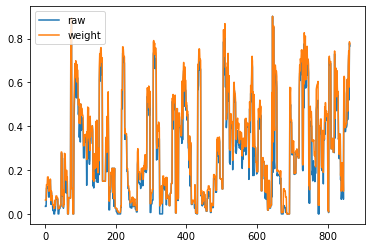

In [441]:
prediction_without_midi_df[['raw', 'weight']].plot()

<AxesSubplot:>

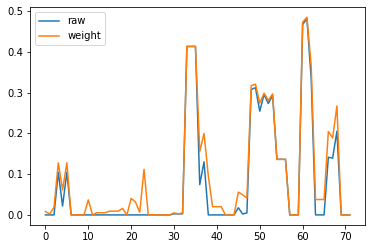

In [442]:
prediction_midi_df[['raw', 'weight']].plot()

In [443]:
group_by_format = prediction_without_midi_df.groupby("format")
print(group_by_format.mean())

group_by_format_midi = prediction_midi_df.groupby("format")
print(group_by_format_midi.mean())

concat_item = [group_by_format.mean(), group_by_format_midi.mean()]
result_group_by_format = pd.concat(concat_item)

print(result_group_by_format)

        song_no       raw    weight
format                             
FI66       12.5  0.291177  0.321003
FI80       12.5  0.341200  0.377222
HU33       12.5  0.213731  0.244204
SC06       12.5  0.245759  0.273722
        song_no       raw   weight
format                            
midi       12.5  0.078126  0.09505
        song_no       raw    weight
format                             
FI66       12.5  0.291177  0.321003
FI80       12.5  0.341200  0.377222
HU33       12.5  0.213731  0.244204
SC06       12.5  0.245759  0.273722
midi       12.5  0.078126  0.095050


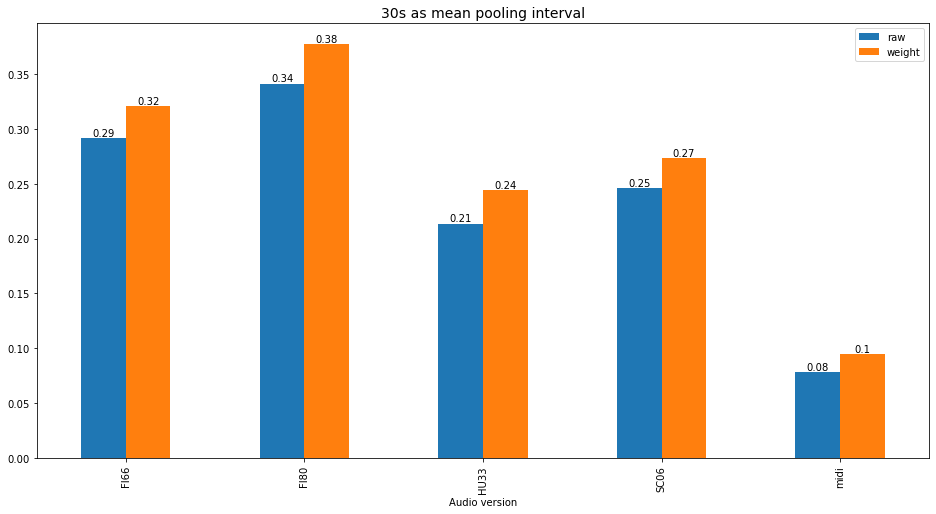

In [444]:
ax = result_group_by_format[['raw', 'weight']].plot(kind='bar', figsize=(16, 8))
ax.set_title('30s as mean pooling interval', fontsize = 14)
for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    ax.set_xlabel('Audio version')

## 不同 template 結果
在此資料集上 ks template 獲得最好的結果，但也只有高出 harmonic 和 binary template 0.01 的分數，差異不是非常的明顯。

In [445]:
group_by_template_type = prediction_without_midi_df.groupby("template_type")
print(group_by_template_type.mean())

               song_no       raw    weight
template_type                             
binary            12.5  0.266115  0.298948
harmonic          12.5  0.273454  0.304738
ks                12.5  0.279332  0.308427


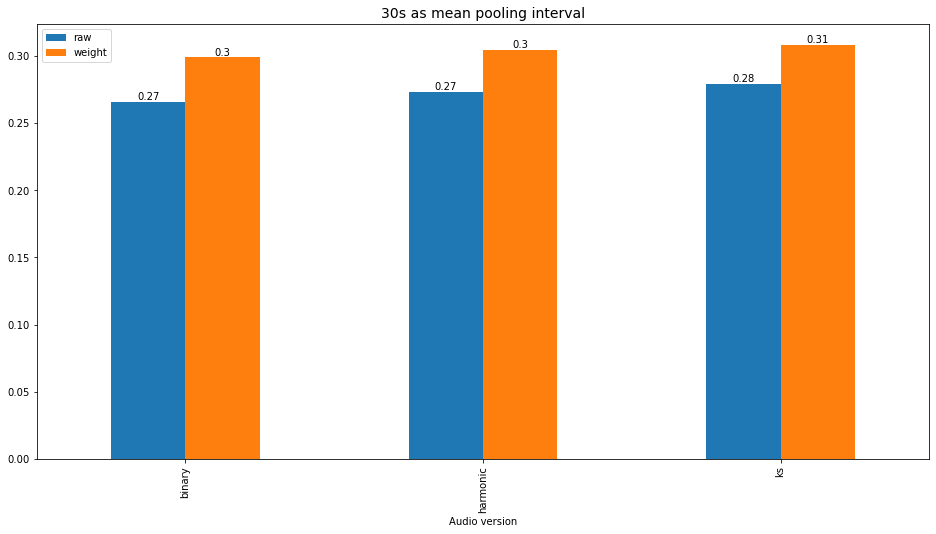

In [446]:
group_by_template_type_mean = group_by_template_type.mean()
ax_template_type = group_by_template_type_mean[['raw', 'weight']].plot(kind='bar', figsize=(16, 8))
ax_template_type.set_title('30s as mean pooling interval', fontsize = 14)
for bar_plot in ax_template_type.patches:
    ax_template_type.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    ax_template_type.set_xlabel('Audio version')

## 不同 spectrogram 擷取方法
透過不同的時頻圖轉換方式，STFT、CQT 及 CENS 獲得 spectrogram 後再轉換為 chromagram。

● STFT：先將輸入訊號分成多個很短的固定時間區塊，透過 window function 的運算，取得 local time window 作瞬時的頻譜近似，每一個時間點都透過傅立葉轉換得到其對應的頻譜。
在此作業使用 window length = 4096 ，是因為 window 長度越能分辨精確的頻率。但當要處理的頻率域範圍非常廣，有些音比較長有些音比較短，很難把每個<br/>
● CQT：如果同一時間有很高音跟很低音同時出現， 但 window 較大適合處理低音，較小適合處理高音，無法兩全其美。使用 CQT 的目標在於對於不同頻帶都要做頻譜分析，每個 moment 都取不同長度的 window 作傅立葉轉換，雖然較麻煩但也較能處理同時出現的高低音分析。採用 log frequency scale，依照 12 平均律在一個八度內取 12 個 scale 。<br/>
● CENS(Chroma Energy Normalized)：CENS 的主要目標是在較長的 window 範圍上進行統計，可以平滑化節奏、發聲和音樂中的裝飾音（ex:顫音和琶音）所造成的局部偏差。chromagram 上可以看出比以上兩者更平滑。<br/>

在下圖中可以看出 CQT 在此資料集上的效果最好，其次是 CENS。

In [447]:
group_by_chroma_operation = prediction_without_midi_df.groupby("chroma_operation")
print(group_by_chroma_operation.mean())

                  song_no       raw    weight
chroma_operation                             
cens                 12.5  0.274282  0.302730
cqt                  12.5  0.293924  0.323390
stft                 12.5  0.250695  0.285993


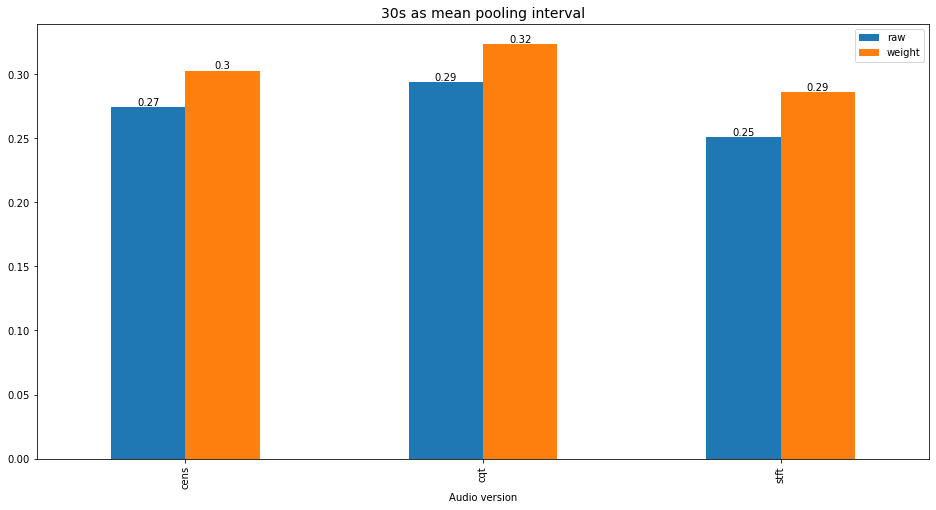

In [448]:
group_by_chroma_operation_mean = group_by_chroma_operation.mean()
ax_template_type = group_by_chroma_operation_mean[['raw', 'weight']].plot(kind='bar', figsize=(16, 8))
ax_template_type.set_title('30s as mean pooling interval', fontsize = 14)
for bar_plot in ax_template_type.patches:
    ax_template_type.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    ax_template_type.set_xlabel('Audio version')

## 不同 mean pool range
以上是以 30s 作為 mean pool 的範圍，但此範圍是否是一個好的選擇可能還需要更多的實驗，因此嘗試以 10s, 20s, 40s 來比較與 30s 作為均值區間的分數效果。
從平均上的結果來看 30s 作為 mean pool 區間是其中表現最好的一個選擇，但是細看其中每首樂曲的表現，未必都是 30s 的最好。這樣的結果可能與曲速有關，或許當曲速較慢時可以使用較長的 interval ，反之。

In [449]:
prediction_dict_100, tempo_dict = prediction_generate(100)
prediction_dict_200, tempo_dict = prediction_generate(200)
prediction_dict_400, tempo_dict = prediction_generate(400)

In [450]:
local_key_prediction_100 = prediction_accuracy(prediction_dict_100)
local_key_prediction_200 = prediction_accuracy(prediction_dict_200)
local_key_prediction_400 = prediction_accuracy(prediction_dict_400)

In [451]:
local_key_prediction_100

{'HU33': {1: {'stft': {'binary': {'raw': 0.13282,
     'weighted': 0.15178055822906644},
    'ks': {'raw': 0.11902, 'weighted': 0.14074430542187988},
    'harmonic': {'raw': 0.13025, 'weighted': 0.1497273018928457}},
   'cqt': {'binary': {'raw': 0.15752, 'weighted': 0.17510426692332406},
    'ks': {'raw': 0.15752, 'weighted': 0.17510426692332406},
    'harmonic': {'raw': 0.15752, 'weighted': 0.17510426692332406}},
   'cens': {'binary': {'raw': 0.17004, 'weighted': 0.1993904395251852},
    'ks': {'raw': 0.17004, 'weighted': 0.1993904395251852},
    'harmonic': {'raw': 0.17004, 'weighted': 0.1993904395251852}}},
  2: {'stft': {'binary': {'raw': 0.10375, 'weighted': 0.12371541501976281},
    'ks': {'raw': 0.10375, 'weighted': 0.12371541501976281},
    'harmonic': {'raw': 0.10375, 'weighted': 0.12371541501976281}},
   'cqt': {'binary': {'raw': 0.12352, 'weighted': 0.13330039525691684},
    'ks': {'raw': 0.11957, 'weighted': 0.13013833992094842},
    'harmonic': {'raw': 0.14723, 'weighted':

In [452]:
local_key_prediction_200

{'HU33': {1: {'stft': {'binary': {'raw': 0.10074,
     'weighted': 0.12027590632017965},
    'ks': {'raw': 0.09689, 'weighted': 0.11719602181584853},
    'harmonic': {'raw': 0.09753, 'weighted': 0.1177093358999037}},
   'cqt': {'binary': {'raw': 0.12159, 'weighted': 0.134584536413218},
    'ks': {'raw': 0.12159, 'weighted': 0.134584536413218},
    'harmonic': {'raw': 0.12159, 'weighted': 0.134584536413218}},
   'cens': {'binary': {'raw': 0.12993, 'weighted': 0.16564003849855724},
    'ks': {'raw': 0.12993, 'weighted': 0.16564003849855724},
    'harmonic': {'raw': 0.12993, 'weighted': 0.16564003849855724}}},
  2: {'stft': {'binary': {'raw': 0.08992, 'weighted': 0.11709486166007906},
    'ks': {'raw': 0.08992, 'weighted': 0.11709486166007906},
    'harmonic': {'raw': 0.08992, 'weighted': 0.11709486166007906}},
   'cqt': {'binary': {'raw': 0.14625, 'weighted': 0.1585968379446642},
    'ks': {'raw': 0.11462, 'weighted': 0.1333003952569168},
    'harmonic': {'raw': 0.15711, 'weighted': 0.16

In [453]:
local_key_prediction_400

{'HU33': {1: {'stft': {'binary': {'raw': 0.01283,
     'weighted': 0.019987167147898614},
    'ks': {'raw': 0.01283, 'weighted': 0.019987167147898614},
    'harmonic': {'raw': 0.01283, 'weighted': 0.019987167147898614}},
   'cqt': {'binary': {'raw': 0.11485, 'weighted': 0.1435354507539306},
    'ks': {'raw': 0.11485, 'weighted': 0.1435354507539306},
    'harmonic': {'raw': 0.11485, 'weighted': 0.1435354507539306}},
   'cens': {'binary': {'raw': 0.14405, 'weighted': 0.19380814886108574},
    'ks': {'raw': 0.14405, 'weighted': 0.19380814886108574},
    'harmonic': {'raw': 0.14405, 'weighted': 0.19380814886108574}}},
  2: {'stft': {'binary': {'raw': 0.09881, 'weighted': 0.1259881422924901},
    'ks': {'raw': 0.09881, 'weighted': 0.1259881422924901},
    'harmonic': {'raw': 0.09881, 'weighted': 0.1259881422924901}},
   'cqt': {'binary': {'raw': 0.17589, 'weighted': 0.1773715415019763},
    'ks': {'raw': 0.14526, 'weighted': 0.152865612648221},
    'harmonic': {'raw': 0.17589, 'weighted': 0

其中 mean pooling 時間較短效果較好，但也不能太短：

In [454]:
# --- 10s
prediction_midi_100 = {"midi":local_key_prediction_100['midi']}
# print(prediction_midi)

prediction_without_midi_100 = local_key_prediction_100
del prediction_without_midi_100['midi']

In [455]:
# --- 20s
prediction_midi_200 = {"midi":local_key_prediction_200['midi']}
# print(prediction_midi)

prediction_without_midi_200 = local_key_prediction_200
del prediction_without_midi_200['midi']

In [456]:
prediction_without_midi_df_100 = pd.DataFrame.from_dict({(i, j, k, m): prediction_without_midi_100[i][j][k][m]
                            for i in prediction_without_midi_100.keys()
                            for j in prediction_without_midi_100[i].keys()
                            for k in prediction_without_midi_100[i][j].keys()
                            for m in prediction_without_midi_100[i][j][k].keys()
                            }, orient='columns').T

prediction_without_midi_df_100.reset_index(inplace=True)
prediction_without_midi_df_100.columns = ['format', 'song_no', 'chroma_operation','template_type', 'raw', 'weight']

prediction_without_midi_df_200 = pd.DataFrame.from_dict({(i, j, k, m): prediction_without_midi_200[i][j][k][m]
                            for i in prediction_without_midi_200.keys()
                            for j in prediction_without_midi_200[i].keys()
                            for k in prediction_without_midi_200[i][j].keys()
                            for m in prediction_without_midi_200[i][j][k].keys()
                            }, orient='columns').T

prediction_without_midi_df_200.reset_index(inplace=True)
prediction_without_midi_df_200.columns = ['format', 'song_no', 'chroma_operation','template_type', 'raw', 'weight']

In [457]:
# print(prediction_midi_200)
prediction_midi_df_100 = pd.DataFrame.from_dict({(i, j, k): prediction_midi_100[i][j][k]
                            for i in prediction_midi_100.keys()
                            for j in prediction_midi_100[i].keys()
                            for k in prediction_midi_100[i][j].keys()
                            }, orient='columns').T

prediction_midi_df_100.reset_index(inplace=True)
prediction_midi_df_100.columns = ['format', 'song_no','template_type', 'raw', 'weight']

prediction_midi_df_200 = pd.DataFrame.from_dict({(i, j, k): prediction_midi_200[i][j][k]
                            for i in prediction_midi_200.keys()
                            for j in prediction_midi_200[i].keys()
                            for k in prediction_midi_200[i][j].keys()
                            }, orient='columns').T

prediction_midi_df_200.reset_index(inplace=True)
prediction_midi_df_200.columns = ['format', 'song_no','template_type', 'raw', 'weight']

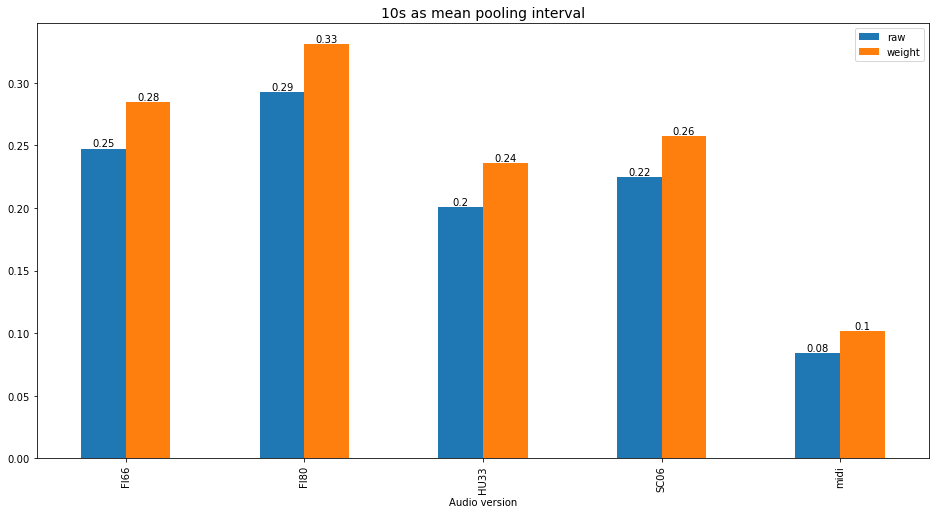

In [458]:
group_by_format_100 = prediction_without_midi_df_100.groupby("format")
group_by_format_midi_100 = prediction_midi_df_100.groupby("format")
concat_item_100 = [group_by_format_100.mean(), group_by_format_midi_100.mean()]
result_group_by_format_100 = pd.concat(concat_item_100)

ax_100 = result_group_by_format_100[['raw', 'weight']].plot(kind='bar', figsize=(16, 8))
ax_100.set_title('10s as mean pooling interval', fontsize = 14)

for bar_plot in ax_100.patches:
    ax_100.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    ax_100.set_xlabel('Audio version')

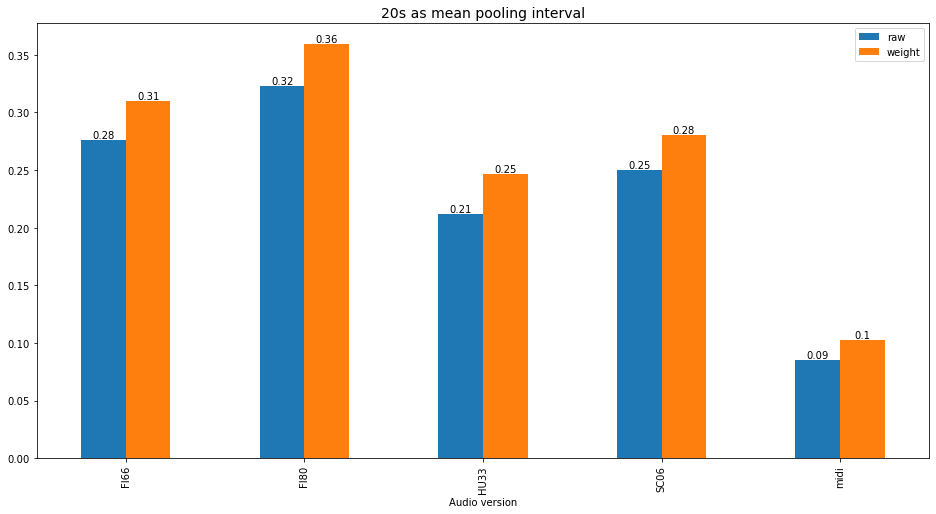

In [459]:
group_by_format_200 = prediction_without_midi_df_200.groupby("format")
group_by_format_midi_200 = prediction_midi_df_200.groupby("format")
concat_item_200 = [group_by_format_200.mean(), group_by_format_midi_200.mean()]
result_group_by_format_200 = pd.concat(concat_item_200)

ax_200 = result_group_by_format_200[['raw', 'weight']].plot(kind='bar', figsize=(16, 8))
ax_200.set_title('20s as mean pooling interval', fontsize = 14)

for bar_plot in ax_200.patches:
    ax_200.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    ax_200.set_xlabel('Audio version')

In [460]:
# --- 40s
prediction_midi_400 = {"midi":local_key_prediction_400['midi']}
# print(prediction_midi)

prediction_without_midi_400 = local_key_prediction_400
del prediction_without_midi_400['midi']

In [461]:
prediction_without_midi_df_400 = pd.DataFrame.from_dict({(i, j, k, m): prediction_without_midi_400[i][j][k][m]
                            for i in prediction_without_midi_400.keys()
                            for j in prediction_without_midi_400[i].keys()
                            for k in prediction_without_midi_400[i][j].keys()
                            for m in prediction_without_midi_400[i][j][k].keys()
                            }, orient='columns').T

prediction_without_midi_df_400.reset_index(inplace=True)
prediction_without_midi_df_400.columns = ['format', 'song_no', 'chroma_operation','template_type', 'raw', 'weight']

In [462]:
prediction_midi_df_400 = pd.DataFrame.from_dict({(i, j, k): prediction_midi_400[i][j][k]
                            for i in prediction_midi_400.keys()
                            for j in prediction_midi_400[i].keys()
                            for k in prediction_midi_400[i][j].keys()
                            }, orient='columns').T

prediction_midi_df_400.reset_index(inplace=True)
prediction_midi_df_400.columns = ['format', 'song_no','template_type', 'raw', 'weight']

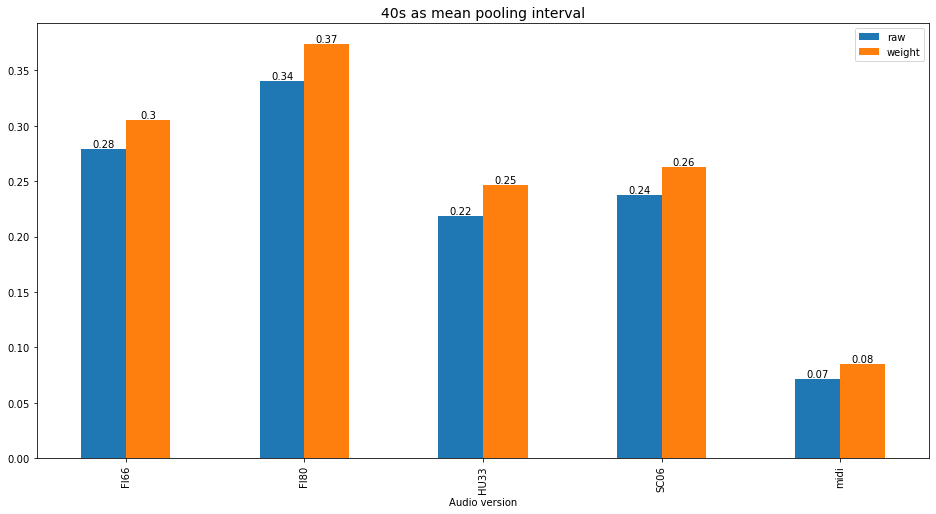

In [463]:
group_by_format_400 = prediction_without_midi_df_400.groupby("format")
group_by_format_midi_400 = prediction_midi_df_400.groupby("format")
concat_item_400 = [group_by_format_400.mean(), group_by_format_midi_400.mean()]
result_group_by_format_400 = pd.concat(concat_item_400)

ax_400 = result_group_by_format_400[['raw', 'weight']].plot(kind='bar', figsize=(16, 8))
ax_400.set_title('40s as mean pooling interval', fontsize = 14)

for bar_plot in ax_400.patches:
    ax_400.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    ax_400.set_xlabel('Audio version')

In [464]:
prediction_dict_500, tempo_dict = prediction_generate(500)
local_key_prediction_500 = prediction_accuracy(prediction_dict_500)

In [465]:
# --- 50s
prediction_midi_500 = {"midi":local_key_prediction_500['midi']}
# print(prediction_midi)

prediction_without_midi_500 = local_key_prediction_500
del prediction_without_midi_500['midi']

In [466]:
prediction_without_midi_df_500 = pd.DataFrame.from_dict({(i, j, k, m): prediction_without_midi_500[i][j][k][m]
                            for i in prediction_without_midi_500.keys()
                            for j in prediction_without_midi_500[i].keys()
                            for k in prediction_without_midi_500[i][j].keys()
                            for m in prediction_without_midi_500[i][j][k].keys()
                            }, orient='columns').T

prediction_without_midi_df_500.reset_index(inplace=True)
prediction_without_midi_df_500.columns = ['format', 'song_no', 'chroma_operation','template_type', 'raw', 'weight']

In [467]:
prediction_midi_df_500 = pd.DataFrame.from_dict({(i, j, k): prediction_midi_500[i][j][k]
                            for i in prediction_midi_500.keys()
                            for j in prediction_midi_500[i].keys()
                            for k in prediction_midi_500[i][j].keys()
                            }, orient='columns').T

prediction_midi_df_500.reset_index(inplace=True)
prediction_midi_df_500.columns = ['format', 'song_no','template_type', 'raw', 'weight']

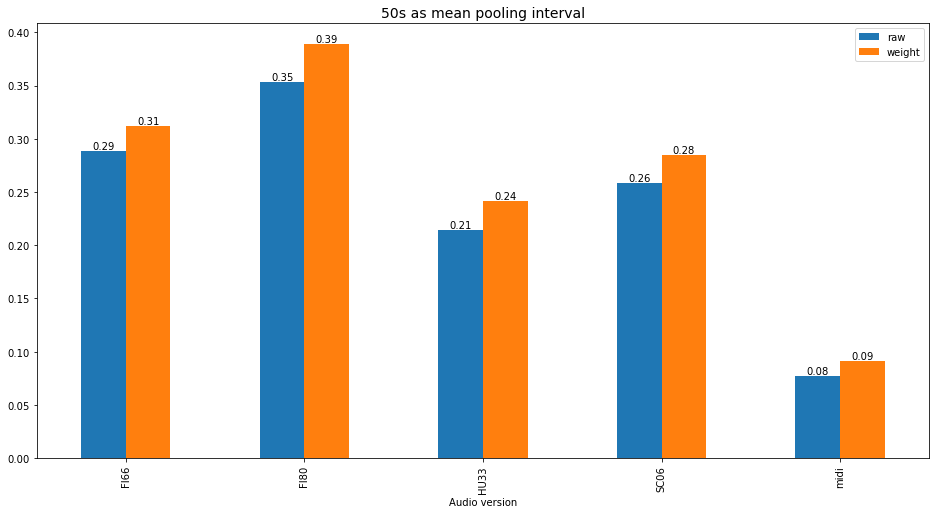

In [468]:
group_by_format_500 = prediction_without_midi_df_500.groupby("format")
group_by_format_midi_500 = prediction_midi_df_500.groupby("format")
concat_item_500 = [group_by_format_500.mean(), group_by_format_midi_500.mean()]
result_group_by_format_500 = pd.concat(concat_item_500)

ax_500 = result_group_by_format_500[['raw', 'weight']].plot(kind='bar', figsize=(16, 8))
ax_500.set_title('50s as mean pooling interval', fontsize = 14)

for bar_plot in ax_500.patches:
    ax_500.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    ax_500.set_xlabel('Audio version')

In [472]:
prediction_dict_600, tempo_dict = prediction_generate(600)
local_key_prediction_600 = prediction_accuracy(prediction_dict_600)

HU33  | song no. 1  | length 3117
HU33  | song no. 2  | length 1012
HU33  | song no. 3  | length 1504
HU33  | song no. 4  | length 1787
HU33  | song no. 5  | length 2745
HU33  | song no. 6  | length 2596
HU33  | song no. 7  | length 1874
HU33  | song no. 8  | length 1234
HU33  | song no. 9  | length 1326
HU33  | song no. 10  | length 1957
HU33  | song no. 11  | length 2546
HU33  | song no. 12  | length 1584
HU33  | song no. 13  | length 1075
HU33  | song no. 14  | length 1833
HU33  | song no. 15  | length 1243
HU33  | song no. 16  | length 1385
HU33  | song no. 17  | length 1978
HU33  | song no. 18  | length 477
HU33  | song no. 19  | length 710
HU33  | song no. 20  | length 2428
HU33  | song no. 21  | length 2212
HU33  | song no. 22  | length 797
HU33  | song no. 23  | length 1892
HU33  | song no. 24  | length 1881
SC06  | song no. 1  | length 3254
SC06  | song no. 2  | length 957
SC06  | song no. 3  | length 1372
SC06  | song no. 4  | length 1599
SC06  | song no. 5  | length 2895
SC0

In [469]:
tempo_dict

{'HU33': {1: array([117.45383523]),
  2: array([112.34714674]),
  3: array([103.359375]),
  4: array([123.046875]),
  5: array([123.046875]),
  6: array([123.046875]),
  7: array([117.45383523]),
  8: array([123.046875]),
  9: array([117.45383523]),
  10: array([129.19921875]),
  11: array([123.046875]),
  12: array([117.45383523]),
  13: array([112.34714674]),
  14: array([123.046875]),
  15: array([129.19921875]),
  16: array([129.19921875]),
  17: array([123.046875]),
  18: array([112.34714674]),
  19: array([117.45383523]),
  20: array([129.19921875]),
  21: array([129.19921875]),
  22: array([107.66601562]),
  23: array([123.046875]),
  24: array([117.45383523])},
 'SC06': {1: array([107.66601562]),
  2: array([117.45383523]),
  3: array([103.359375]),
  4: array([123.046875]),
  5: array([123.046875]),
  6: array([135.99917763]),
  7: array([103.359375]),
  8: array([129.19921875]),
  9: array([107.66601562]),
  10: array([103.359375]),
  11: array([123.046875]),
  12: array([129

## 以下待修正

但實際上會影響 detection 分數的因素不僅有檔案格式，還有錄音環境和設備的差異。<br/>
在聽過四種錄音檔案後可以發現：<br/>
● SC06 的檔案響度較小，音質清澈環境，但可能因為錄音距離較遠且採樣較細緻所以環境底噪（翻譜、腳步移動、踏板聲較清晰），推測此錄音應該釋教接近現在年份的，但或許太過細緻的錄音也會收錄許多的雜音，進而導致音訊取樣資料上的變異性及不確定性。<br/>
● HU33 響度更小且雜音十分明顯，感覺是年代非常久遠的錄音檔案，可能是受到過去錄音設備品質的限制，導致音訊資料雜音幾乎可以說比演奏更清楚，而這些人耳聽起來只是「嘈雜」的噪音，對電腦而言都是具有相對應音高的，因此在提取 chromagram 特徵時這些噪音應該便會造成能量分佈失真。<br/>
● FI80 的檔案響度較前兩者就大很多，音場上的感受人聲在收錄時偏右鋼琴偏左，且聽起來的音質乾淨清澈，錄音年代也應較接近現在，雖然是使用 mp3 這樣的壓縮檔案格式，但只要是這樣清晰的錄音對於電腦而言也會降低許多干擾，使偵測結果有較好的表現。<br/>
● FI66 的檔案響度再較 FI80 大一點，感覺與人聲錄音的距離較近，但是人耳聽起來有較明顯的雜訊，但應該也只是受到錄音設備限制，其在收錄上的表現較清晰，錄音時離樂器和演唱加較近也可以避免收錄到音樂以外的雜音。<br/>

以上皆是自己聽起來的感覺可能不夠準確，因此經過查詢資料集的資料，或許相對應檔案的 annotation 也是影響 accuracy 的一大因素。根據 Schubert Winterreise Dataset 的製作 https://dl.acm.org/doi/fullHtml/10.1145/3429743 ，可以得知 HU33, SC06 兩者的標記是人工標記的，相比其他版本的標記更加可靠。而就是這些較可靠的資料標記可能使辨識比較嚴格。<br/>